# Lesson 5.2a: Choosing Good Collective Variables for Multi-Dimensional Systems

**Corresponding Module in Course Outline:** Module 5: The Challenge of Sampling
**Prerequisites:** Understanding of basic MD concepts, Potential Energy Surfaces (PES), and an introduction to Collective Variables (CVs) from Lesson 5.2. Familiarity with Python, NumPy, and Matplotlib is assumed for running the code cells.

## 1. Introduction: The Dimensionality Dilemma

In molecular simulations, we often deal with systems containing many atoms. For $N$ atoms in 3D space, the system has $3N$ degrees of freedom (excluding overall translation and rotation if not relevant). Describing the complex conformational changes, reactions, or binding events in this high-dimensional space is incredibly challenging.

**Collective Variables (CVs)** are functions of the atomic coordinates that help us reduce this dimensionality. They are chosen to capture the essential slow motions or important transitions in the system. We often want to understand the system's behavior in terms of a few (typically 1 to 3) CVs, allowing us to visualize and analyze the free energy landscape.

However, the choice of CVs is crucial. A poor choice can obscure important features of the landscape, while a good choice can reveal the underlying mechanisms of the process we are studying.

**Why is visualization a challenge?**
We can typically visualize:
* 1 CV: A 1D plot (e.g., PMF along a coordinate).
* 2 CVs: A 2D contour plot or surface plot (e.g., PMF as a function of two CVs).
* 3 CVs: This is already difficult, often requiring slices or projections.

Since our simulation data is $3N$-dimensional, and we can only effectively visualize landscapes in 2D or 3D (using 2 CVs for the axes and the PMF as the third dimension/color), we need to be very careful about which aspects of the $3N$-dimensional space our chosen CVs represent.

In this notebook, we'll explore how to evaluate the "goodness" of CVs by looking at a 2D PMF and then examining 1D "slices" or projections along different potential CVs.

## 2. Simulating a 2D System (Conceptual)

Imagine we have run a long MD simulation of a system that can be effectively described by two coordinates, let's call them $q_1$ and $q_2$. From this simulation, we can calculate the probability distribution $P(q_1, q_2)$ of finding the system at particular values of $q_1$ and $q_2$. The Potential of Mean Force (PMF) is then given by:

$F(q_1, q_2) = -k_B T \ln P(q_1, q_2)$

(For simplicity, we'll often set $k_B T = 1$ and ignore the constant offset, focusing on relative free energies: $F(q_1, q_2) \propto -\ln P(q_1, q_2)$).

For this notebook, instead of running a full MD simulation and calculating the PMF (which is computationally intensive), we will generate a synthetic 2D PMF that mimics a system with two stable states separated by an energy barrier. This will allow us to focus on the principles of CV selection.

Let's define our synthetic 2D probability distribution $P(x,y)$ as the sum of two Gaussian functions. This represents a system with two preferred regions (basins) in the $(x,y)$ plane.

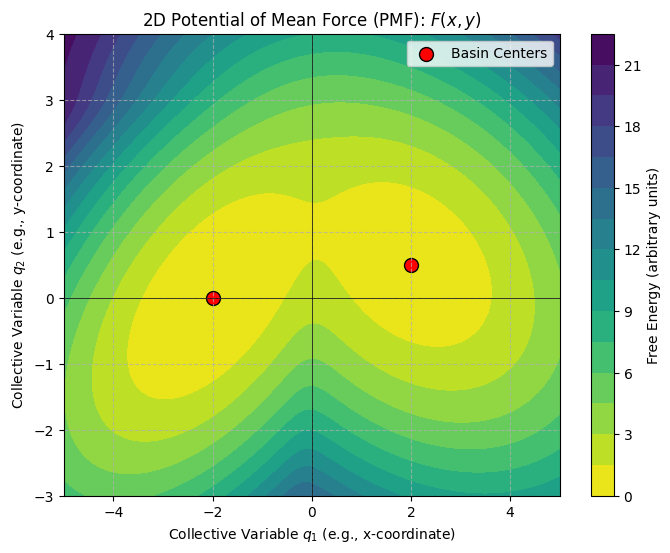

Shape of X: (100, 100)
Shape of Y: (100, 100)
Shape of F_xy: (100, 100)
Min F_xy: 0.0, Max F_xy: 21.326964502688934


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# --- Configuration for the 2D PMF ---
# Define the means (centers) of the two basins
mean1 = [-2, 0]
mean2 = [2, 0.5] # Slightly offset in y for a bit more complexity

# Define the covariance matrices (spread and orientation)
# Making them slightly elliptical and differently oriented
cov1 = [[1.0, 0.5], [0.5, 0.8]]
cov2 = [[1.2, -0.3], [-0.3, 0.7]]

# Amplitudes of the Gaussians (can be adjusted)
amp1 = 1.0
amp2 = 0.8

# Create a grid of points
x_coords = np.linspace(-5, 5, 100)
y_coords = np.linspace(-3, 4, 100)
X, Y = np.meshgrid(x_coords, y_coords)
pos = np.dstack((X, Y))

# Create the multivariate Gaussian distributions
rv1 = multivariate_normal(mean1, cov1)
rv2 = multivariate_normal(mean2, cov2)

# Calculate the probability distribution P(x,y)
# This is a sum of two Gaussians, representing two populated states
P_xy = amp1 * rv1.pdf(pos) + amp2 * rv2.pdf(pos)

# Calculate the PMF F(x,y) = -log(P(x,y))
# Adding a small epsilon to avoid log(0) if P_xy can be zero
epsilon = 1e-10
F_xy = -np.log(P_xy + epsilon)

# Normalize PMF to have a minimum of 0 for easier visualization
F_xy = F_xy - np.min(F_xy)

# --- Plotting the 2D PMF ---
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, F_xy, levels=20, cmap='viridis_r') # '_r' reverses the colormap
plt.colorbar(contour, label='Free Energy (arbitrary units)')
plt.title('2D Potential of Mean Force (PMF): $F(x, y)$')
plt.xlabel('Collective Variable $q_1$ (e.g., x-coordinate)')
plt.ylabel('Collective Variable $q_2$ (e.g., y-coordinate)')
plt.scatter([mean1[0], mean2[0]], [mean1[1], mean2[1]], color='red', s=100, edgecolor='black', label='Basin Centers')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")
print(f"Shape of F_xy: {F_xy.shape}")
print(f"Min F_xy: {np.min(F_xy)}, Max F_xy: {np.max(F_xy)}")


### 3D Surface Plot of the 2D PMF

Below is a 3D surface representation of our 2D PMF. This view can help visualize the height of barriers and depth of basins more intuitively.



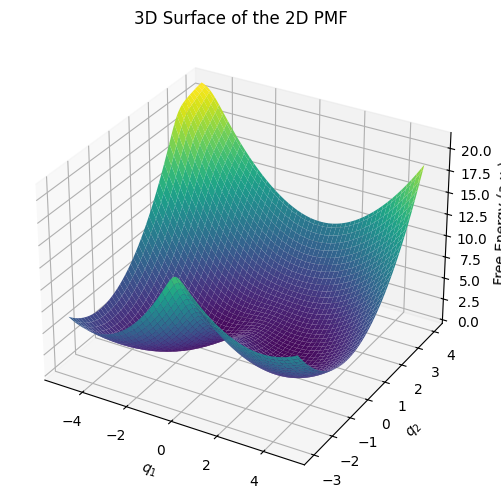

In [2]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, F_xy, cmap='viridis', edgecolor='none')
ax.set_title('3D Surface of the 2D PMF')
ax.set_xlabel('$q_1$')
ax.set_ylabel('$q_2$')
ax.set_zlabel('Free Energy (a.u.)')
plt.show()


## 3. Interpreting the 2D PMF

The plot above shows our synthetic 2D PMF.
* The dark regions represent low free energy (stable states or basins).
* The lighter regions represent high free energy (energy barriers or unstable regions).
* We can see two main basins, indicating two preferred states of our system.
* The "path" between these basins goes over an energy barrier (a saddle point).

Our goal is to find a single CV that can effectively describe the transition between these two basins. If we had to pick just *one* CV from $q_1$ (x-coordinate) or $q_2$ (y-coordinate), which one would be better?

## 4. "Slicing" the PMF: Projecting onto 1D CVs

If we only consider one CV, say $q_1$, we are essentially looking at a "projection" or an "average" of the 2D PMF onto the $q_1$ axis. The 1D PMF along $q_1$, $F(q_1)$, can be obtained by integrating out the other variable $q_2$:

$P(q_1) = \int P(q_1, q_2) dq_2$
$F(q_1) = -k_B T \ln P(q_1)$

Similarly for $F(q_2)$:

$P(q_2) = \int P(q_1, q_2) dq_1$
$F(q_2) = -k_B T \ln P(q_2)$

In practice, with gridded data, this integration becomes a summation over the rows or columns of our $P(q_1, q_2)$ matrix.

Let's consider two candidate CVs:
1.  **CV A:** The $x$-coordinate ($q_1$).
2.  **CV B:** The $y$-coordinate ($q_2$).

We will now calculate and plot the 1D PMF profiles along each of these candidate CVs.

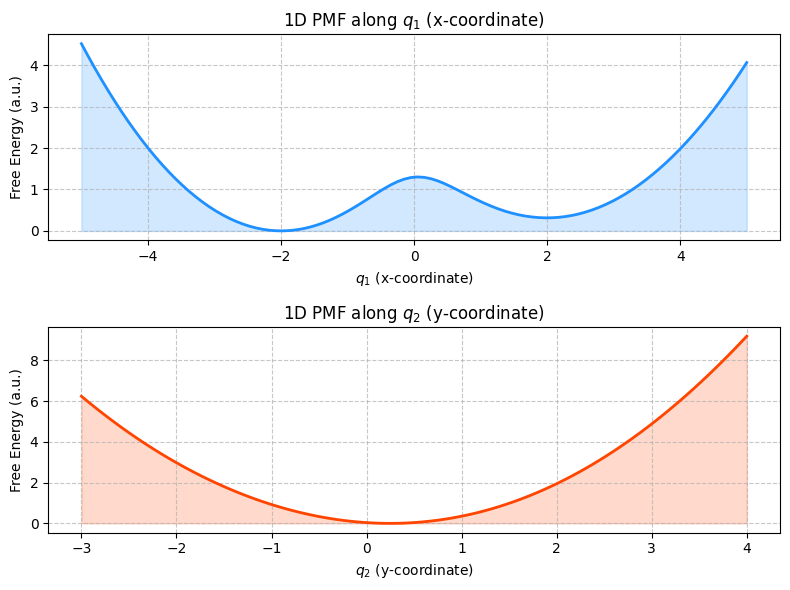

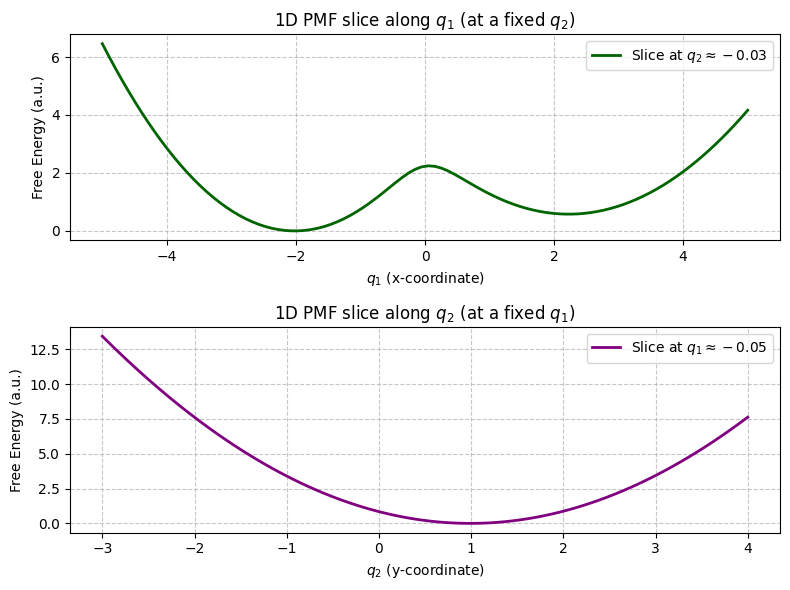

In [7]:
# --- Calculate 1D PMFs by integrating (summing) P_xy ---

# P(q1) = sum over q2 of P(q1, q2)
# Remember P_xy has shape (len(y_coords), len(x_coords)) because of meshgrid output
# So, to sum over y_coords (q2), we sum along axis 0
P_q1 = np.sum(P_xy, axis=0) * (y_coords[1] - y_coords[0]) # Multiply by dy for integral approximation
F_q1 = -np.log(P_q1 + epsilon) # epsilon defined in previous cell
F_q1 = F_q1 - np.min(F_q1) # Normalize

# P(q2) = sum over q1 of P(q1, q2)
# To sum over x_coords (q1), we sum along axis 1
P_q2 = np.sum(P_xy, axis=1) * (x_coords[1] - x_coords[0]) # Multiply by dx for integral approximation
F_q2 = -np.log(P_q2 + epsilon)
F_q2 = F_q2 - np.min(F_q2) # Normalize

# --- Plotting the 1D PMFs ---
fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=False)

# Plot F(q1)
axs[0].plot(x_coords, F_q1, linewidth=2, color='dodgerblue')
axs[0].set_title('1D PMF along $q_1$ (x-coordinate)')
axs[0].set_xlabel('$q_1$ (x-coordinate)')
axs[0].set_ylabel('Free Energy (a.u.)')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].fill_between(x_coords, F_q1, alpha=0.2, color='dodgerblue')

# Plot F(q2)
axs[1].plot(y_coords, F_q2, linewidth=2, color='orangered')
axs[1].set_title('1D PMF along $q_2$ (y-coordinate)')
axs[1].set_xlabel('$q_2$ (y-coordinate)')
axs[1].set_ylabel('Free Energy (a.u.)')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].fill_between(y_coords, F_q2, alpha=0.2, color='orangered')

plt.tight_layout()
plt.show()

# --- Alternative: Taking a direct slice (less rigorous but illustrative) ---
# For example, a slice along x_coords at y_coords=0 (or closest y_coords to 0)
y_slice_idx = np.argmin(np.abs(y_coords - 0))
F_slice_q1_at_y0 = F_xy[y_slice_idx, :]
F_slice_q1_at_y0 = F_slice_q1_at_y0 - np.min(F_slice_q1_at_y0)

# A slice along y_coords at x_coords=0 (or closest x_coords to 0)
x_slice_idx = np.argmin(np.abs(x_coords - 0))
F_slice_q2_at_x0 = F_xy[:, x_slice_idx]
F_slice_q2_at_x0 = F_slice_q2_at_x0 - np.min(F_slice_q2_at_x0)

fig, axs_slice = plt.subplots(2, 1, figsize=(8, 6), sharex=False)

axs_slice[0].plot(x_coords, F_slice_q1_at_y0, linewidth=2, color='darkgreen', label=f'Slice at $q_2 \\approx {y_coords[y_slice_idx]:.2f}$')
axs_slice[0].set_title('1D PMF slice along $q_1$ (at a fixed $q_2$)')
axs_slice[0].set_xlabel('$q_1$ (x-coordinate)')
axs_slice[0].set_ylabel('Free Energy (a.u.)')
axs_slice[0].grid(True, linestyle='--', alpha=0.7)
axs_slice[0].legend()

axs_slice[1].plot(y_coords, F_slice_q2_at_x0, linewidth=2, color='purple', label=f'Slice at $q_1 \\approx {x_coords[x_slice_idx]:.2f}$')
axs_slice[1].set_title('1D PMF slice along $q_2$ (at a fixed $q_1$)')
axs_slice[1].set_xlabel('$q_2$ (y-coordinate)')
axs_slice[1].set_ylabel('Free Energy (a.u.)')
axs_slice[1].grid(True, linestyle='--', alpha=0.7)
axs_slice[1].legend()

plt.tight_layout()
plt.show()


### Quantitative Comparison: Barrier Heights

Let's compute and compare the energy barrier heights along each CV. A higher barrier indicates better resolution of transitions.



Barrier height along $q_1$: 4.52 a.u.
Barrier height along $q_2$: 9.19 a.u.


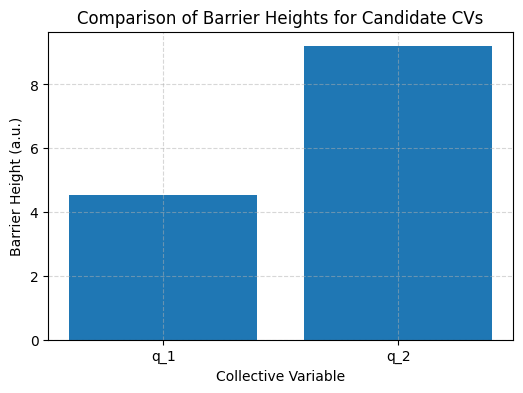

In [4]:

# Compute global barrier heights as max minus min of each PMF
barrier_height_q1 = np.max(F_q1) - np.min(F_q1)
barrier_height_q2 = np.max(F_q2) - np.min(F_q2)

print(f"Barrier height along $q_1$: {barrier_height_q1:.2f} a.u.")
print(f"Barrier height along $q_2$: {barrier_height_q2:.2f} a.u.")

# Plotting barrier heights
cv_names = ['q_1', 'q_2']
heights = [barrier_height_q1, barrier_height_q2]

plt.figure(figsize=(6, 4))
plt.bar(cv_names, heights)
plt.title('Comparison of Barrier Heights for Candidate CVs')
plt.ylabel('Barrier Height (a.u.)')
plt.xlabel('Collective Variable')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


## 5. Comparing CVs: Which One is "Good" and Which is "Bad"?

Now, let's analyze the 1D PMF profiles we generated.

**Looking at $F(q_1)$ (PMF along the x-coordinate):**
* This profile clearly shows two distinct minima (low free energy regions).
* It also shows a significant energy barrier separating these two minima.
* This profile captures the essential features of our 2D landscape: the existence of two stable states and the energy cost to transition between them.
* Therefore, $q_1$ (the x-coordinate) appears to be a **"good" CV** for describing the transition between the two basins in our synthetic system.

**Looking at $F(q_2)$ (PMF along the y-coordinate):**
* This profile might show one broad minimum, or perhaps some minor wiggles, but it *does not* clearly resolve the two distinct stable states we saw in the 2D PMF.
* The energy barrier between the states is not apparent when looking only along $q_2$.
* If we only used $q_2$ as our CV, we might mistakenly conclude that there's only one main state or that the energy landscape is relatively flat or uninteresting.
* Therefore, $q_2$ (the y-coordinate) appears to be a **"bad" CV** for describing the primary transition in this particular system. It averages out or obscures the important features.

**What about the "direct slice" plots?**
The second set of plots shows 1D PMFs taken as direct slices through the 2D PMF (e.g., $F(q_1, q_2=0)$).
* The slice along $q_1$ (at $q_2 \approx 0$) still captures the two-well nature because the main separation of basins is along $q_1$.
* The slice along $q_2$ (at $q_1 \approx 0$) might cut through the barrier region or one of the basins, but it likely won't show the full picture of transitioning between the two distinct states.
* While slices can be informative, projecting the full probability (by integrating) is generally a more robust way to obtain the 1D PMF along a CV, as it accounts for all contributions from the dimension being integrated out.

## 6. What Makes a CV "Good"?

A "good" CV should ideally:
1.  **Distinguish between important metastable states:** The PMF along a good CV should show distinct minima corresponding to these states.
2.  **Capture the transition pathway:** It should clearly show the energy barriers that separate these states.
3.  **Represent the slowest motions:** Often, the important conformational changes or reactions are the slowest processes in the system. A good CV should align with these slow degrees of freedom.
4.  **Be physically interpretable:** While not strictly necessary for a mathematically sound CV, it's highly desirable if the CV corresponds to an understandable geometric feature or physical process (e.g., a distance, an angle, a coordination number).
5.  **Lead to converged PMFs:** Enhanced sampling methods (like Umbrella Sampling or Metadynamics, which you'll learn about soon) rely on CVs. A good CV will allow these methods to efficiently sample the landscape and converge to a reliable PMF.

**Why was $q_1$ good and $q_2$ bad in our example?**
Our synthetic 2D PMF was constructed such that the two main basins were primarily separated along the $q_1$ (x-axis) direction. The variation along $q_2$ (y-axis) was less significant for distinguishing these two main states.

## 7. Choosing CVs in Real Systems - An Iterative Process

In real molecular simulations, you don't have a pre-defined 2D PMF to look at before choosing your CVs. The process is often iterative and requires chemical intuition:

1.  **Hypothesize CVs:** Based on your understanding of the system and the process you're studying (e.g., protein folding, ligand binding, chemical reaction), propose a set of candidate CVs. These could be distances between key atoms, dihedral angles, radius of gyration, number of hydrogen bonds, etc.
2.  **Run Simulations:** Perform initial (often unbiased) MD simulations or short biased simulations using your candidate CVs.
3.  **Analyze Trajectories:** Project your simulation trajectories onto these CVs.
    * Look at the time evolution of the CVs. Do they show transitions between different states?
    * Calculate preliminary 1D or 2D PMFs (if possible, using techniques like histogramming or WHAM if you have biased data).
4.  **Evaluate CVs:**
    * Does the PMF along a CV show clear states and barriers?
    * If using two CVs, does the 2D PMF reveal a sensible landscape?
    * Are there other, potentially better, CVs that might capture motions you're missing? For example, if your 2D PMF shows distinct basins but they are not well separated along either of your chosen CV axes alone, perhaps a linear combination of them, or a different CV altogether, is needed.
5.  **Refine and Repeat:** Based on the analysis, refine your choice of CVs and repeat the process. You might try adding more CVs, removing uninformative ones, or defining new, more complex CVs.

This process can be challenging and is often a critical part of studying complex molecular events. Tools like Principal Component Analysis (PCA) or Time-lagged Independent Component Analysis (TICA) can sometimes help identify good CVs from simulation data by finding the directions of highest variance or slowest dynamics, respectively.

## 8. Conclusion

Choosing appropriate collective variables is fundamental for understanding complex processes in molecular simulations. By reducing the high dimensionality of the system to a few key coordinates, we can visualize free energy landscapes, identify important states and transition pathways, and apply powerful enhanced sampling techniques.

As we saw in this notebook, a "good" CV provides a clear and informative projection of the system's behavior, while a "bad" CV can obscure important details. The example of projecting a 2D PMF onto 1D profiles illustrates how different CV choices can lead to vastly different interpretations of the underlying free energy landscape. Always critically assess your CVs and be prepared to iterate on your choices!

**Next Steps:**
* Experiment with the parameters in the Python code (e.g., `mean1`, `mean2`, `cov1`, `cov2`) to see how the 2D PMF and the resulting 1D projections change.
* Consider what would happen if the basins were separated diagonally. Would $q_1$ or $q_2$ alone be good CVs? What might be a better CV in that case? (Hint: a combination of $q_1$ and $q_2$).
* Think about real chemical systems you know. What CVs might be appropriate to describe their important conformational changes?

This understanding will be crucial as you move on to learn about enhanced sampling methods like Umbrella Sampling and Metadynamics, which heavily rely on well-chosen CVs.